In [1]:
# use SAM model to segment the image

import os
import pickle
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import (
    SamAutomaticMaskGenerator, sam_model_registry,
    SamPredictor
)

from utils import show_mask, show_box, get_device

# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [3]:
device = get_device()

sam_checkpoint = "/Users/naman/Workspace/Data/BM5020-POEM/sam_vit_h_4b8939.pth"
# sam_checkpoint = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

In [236]:
im_dir = "/Users/naman/Workspace/Data/BM5020-POEM/Annotated"
im_paths = [f"{im_dir}/{im_file}" for im_file in os.listdir(im_dir)]
pkl_path = f"{im_dir}/annotations.pkl"

path_iter = iter(im_paths)

In [220]:
with open(pkl_path, "rb") as file:
    all_masks = pickle.load(file)

len(all_masks)

9

---

M_01112024131028_20696889_1_001_0002-01.MP4-frame8762.jpg


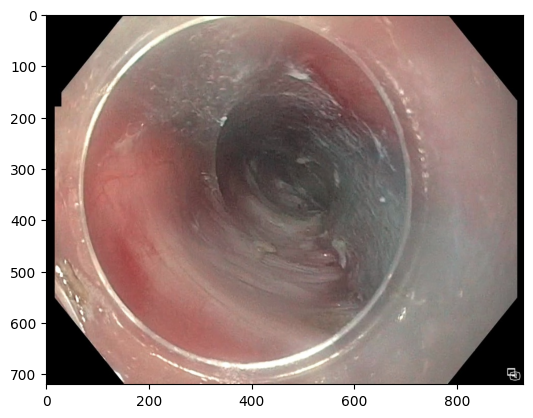

In [279]:
im_path = next(path_iter)
filename = os.path.split(im_path)[1]
while (os.path.splitext(im_path)[1] != ".jpg") or (filename in all_masks.keys()):
    im_path = next(path_iter)
    filename = os.path.split(im_path)[1]

print(filename)
image = cv2.imread(im_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)
plt.imshow(image)
plt.show()

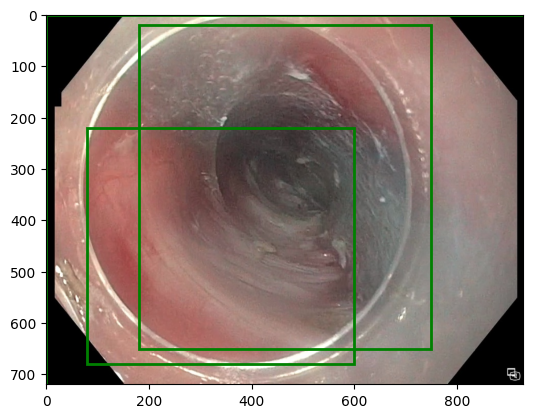

In [284]:
input_boxes = torch.tensor([

    # 0 - Background (Null class)
    [0, 0, *image.shape[-2::-1]],

    # 1 - Muscle layer
    [80, 220, 600, 680],

    # 2 - Mucosal layer
    [180, 20, 750, 650],

    # 3 - Electrode
    [0, 0, 0, 0]

]).to(device)

plt.imshow(image)
for box in input_boxes:
    show_box(box.cpu(), plt.gca())
plt.show()

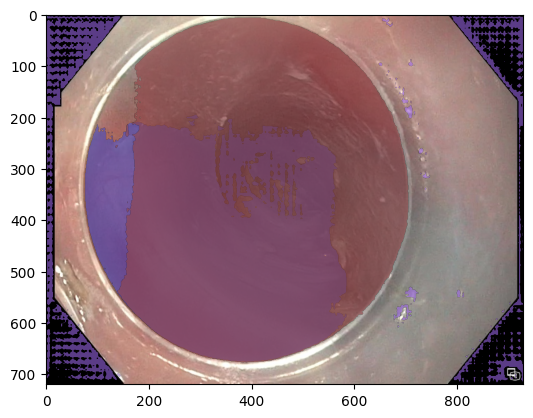

In [286]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.show()

In [287]:
all_masks[filename] = masks.squeeze().argmax(0).cpu()

---

In [278]:
len(all_masks)

13

In [217]:
with open(pkl_path, "wb") as file:
    pickle.dump(all_masks, file)

In [29]:
image = cv2.imread("img.jpg")

# image = cv2.imread("tiger.jpg")

In [30]:
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

26
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


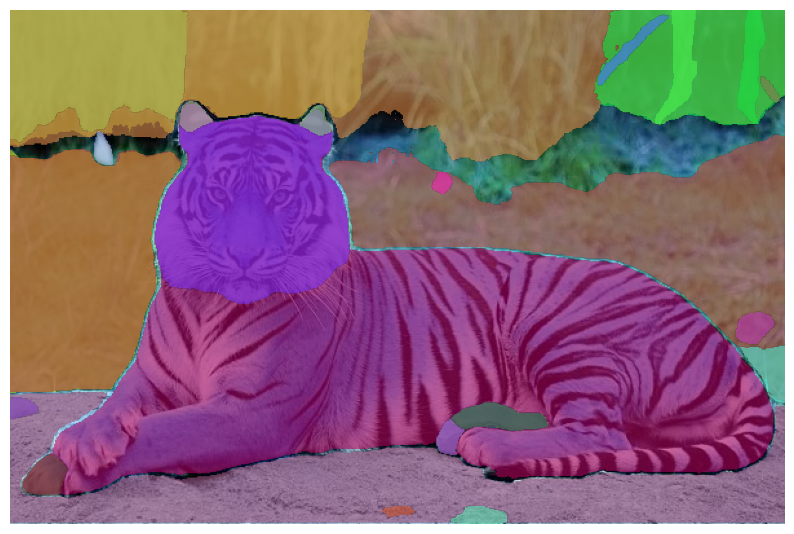

In [32]:
plt.imshow(image)
for mask in masks:
    show_mask(mask["segmentation"], plt.gca(), random_color=True)
plt.axis('off')
plt.show() 